# SWEATER

In [93]:
import pandas as pd
import numpy as np

from scipy import signal
import scipy.linalg as la
from scipy.stats import norm
from scipy.integrate import trapz
import math as m
import pywt

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
from matplotlib.gridspec import GridSpec

## Load the original data

In [2]:
# original dataset
DF = pd.read_csv('4_Chest_sweater.txt',sep='\t')
DF

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,100,1555414552,687.836,380.823,580.354,-7.926829,8.048780,0.975610,-592,122,-113,0.788006,0.002899,-0.432874,-0.437788
1,5,100,1555414552,-812.703,-108.946,726.876,-11.707320,-81.829270,8.780488,125,60,-128,0.183978,-0.428877,0.002594,0.884426
2,5,100,1555414552,-812.520,-108.824,733.952,-37.073170,-145.487800,14.756100,123,59,-136,0.128994,-0.427229,0.000702,0.894894
3,5,100,1555414552,-787.144,-45.628,616.954,-56.341460,-174.634200,23.048780,118,58,-145,0.113618,-0.421033,-0.001770,0.899899
4,5,100,1555414552,-800.259,-137.433,411.689,-1.097561,37.073170,1.341463,113,57,-157,0.107202,-0.424787,-0.001251,0.898923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14933,5,100,1555415471,-890.722,-81.008,446.764,-2.682927,2.926829,0.365854,144,47,-50,0.017279,0.534410,0.040437,-0.844081
14934,5,100,1555415471,-885.964,-76.006,459.025,-3.902439,3.292683,0.365854,146,45,-51,0.016416,0.535050,0.041231,-0.843654
14935,5,100,1555415471,-879.681,-77.714,475.068,-3.048780,2.804878,0.365854,144,46,-54,0.015920,0.534349,0.041780,-0.844081
14936,5,100,1555415471,-894.992,-76.311,502.701,0.121951,1.463415,0.609756,144,45,-53,0.015192,0.531663,0.041749,-0.845790


## Select only the meaningful data

La frequenza di campionamento per questo dataset è 'Log Freq' a 100Hz.

L'intervallo significativo di dati è quello evidenziato nei grafici sottostanti: [10,140] s. A questo punto il tempo è stato riscalato, in modo che la prima misurazione significativa corrisponda a 0s.

Text(0, 0.5, 'Magnetic Field [mG]')

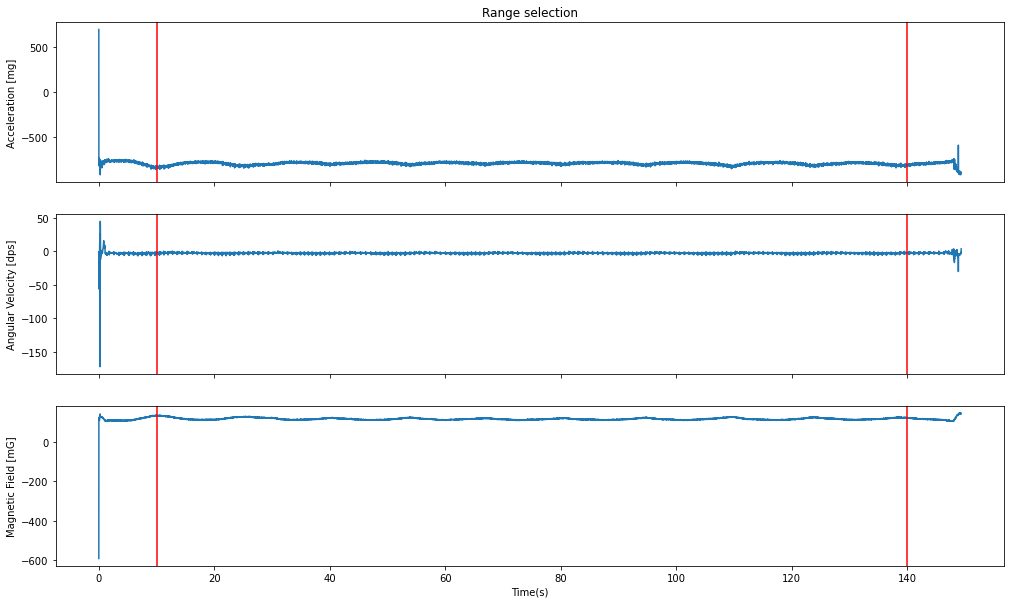

In [4]:
# plot raw data
(fig, (ax1,ax2,ax3)) = plt.subplots(3,1,figsize=(17,10), sharex=True)

t = np.arange(0, len(DF['AccX']))/DF['Log Freq'][0]
ax1.plot(t, DF['AccX'])
ax1.axvline(x = 10, color = 'red')
ax1.axvline(x = 140, color = 'red')
ax1.set_ylabel('Acceleration [mg]')
ax1.set_title('Range selection')

ax2.plot(t, DF['GyroX'])
ax2.axvline(x = 10, color = 'red')
ax2.axvline(x = 140, color = 'red')
ax2.set_ylabel('Angular Velocity [dps]')

ax3.plot(t, DF['MagnX'])
ax3.axvline(x = 10, color = 'red')
ax3.axvline(x = 140, color = 'red')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Magnetic Field [mG]') 


Le colonne di maggior interesse sono quelle contenenti le misurazioni fatte da Accelerometro(mg), Giroscopio(dps), Magnetometro(mG) e i relativi tempi(s). Per le stesse ragioni del caso dello sterno, si sono scartati i quaternioni.

In [5]:
# new dataset with only the interesting data
a = 1000
b = 14000
freq = DF['Log Freq'][0]
df = DF.iloc[a:b+1]    
df = df.drop(['Log Mode', 'Log Freq', 'Timestamp','qw', 'qi', 'qj', 'qk'], axis=1) 
df['Time'] = np.arange(0, len(df['AccX']))/freq
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1000,-822.219,-105.957,579.012,-1.829268,0.609756,0.609756,132,56,-101,0.00
1001,-818.498,-111.386,577.731,-2.682927,0.731707,0.731707,133,57,-101,0.01
1002,-827.587,-108.214,577.670,-4.512195,0.609756,0.731707,134,57,-100,0.02
1003,-829.600,-110.105,570.594,-3.536585,1.463415,0.731707,135,56,-103,0.03
1004,-833.260,-108.824,563.701,-2.195122,1.341463,0.609756,133,56,-101,0.04
...,...,...,...,...,...,...,...,...,...,...
13996,-807.213,-78.019,617.259,-2.682927,0.609756,0.365854,123,45,-116,129.96
13997,-803.980,-72.041,616.344,-2.682927,1.219512,0.609756,122,46,-114,129.97
13998,-803.065,-78.934,597.068,-2.804878,1.097561,0.243902,122,45,-114,129.98
13999,-802.211,-79.788,614.697,-2.682927,1.829268,0.243902,122,45,-113,129.99


## Calibration
Di seguito è riportata la procedura di calibrazione eseguita sul dataset.

In [6]:
# calibration matrices and offset vectors
gyro_off = np.array([-2.804399, 1.793105, 0.3411708])
acc_cal = np.array([[1.002982, 9.415505E-05, 0.004346743],
                    [9.04459E-05, 1.002731, -0.001444198], 
                    [0.004346536, -0.001444751,	1.030587]])
acc_off = np.array([3.602701, -20.96658, 54.97186])
magn_cal = np.array([[1.013437, -0.04728858, -0.001861475], 
                    [-0.04728862, 1.004832, 0.008222118],    
                    [-0.001861605, 0.008221965, 0.9439077]])
magn_off = np.array([-150.4098, 74.62431, 630.9805])

In [7]:
# calibration procedure
df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyro_off.T
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']],acc_cal.T) + acc_off.T
df[['MagnX','MagnY','MagnZ']] = np.dot(df[['MagnX','MagnY','MagnZ']],magn_cal.T) + magn_off.T
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1000,-818.561316,-128.123523,648.273377,-4.633667,2.402861,0.950927,-19.096268,123.822370,535.860520,0.00
1001,-814.835299,-133.565163,646.977212,-5.487326,2.524812,1.072878,-18.130119,124.779914,535.866881,0.01
1002,-823.951369,-130.385234,646.870258,-7.316594,2.402861,1.072878,-17.118544,124.740847,536.808927,0.02
1003,-826.001308,-132.271361,639.571807,-6.340984,3.256520,1.072878,-16.052234,123.664060,533.967120,0.03
1004,-829.702063,-130.977239,632.450211,-4.999521,3.134568,0.950927,-18.082831,123.775082,535.858659,0.04
...,...,...,...,...,...,...,...,...,...,...
13996,-803.341688,-100.163103,687.715099,-5.487326,2.402861,0.707024,-27.669104,113.071484,521.628218,129.96
13997,-800.102461,-94.167163,686.777527,-5.487326,3.012617,0.950927,-28.733553,114.140049,523.526117,129.97
13998,-799.269170,-101.051067,666.925868,-5.609277,2.890666,0.585073,-28.686264,113.135217,523.517895,129.98
13999,-798.336075,-101.932782,685.099032,-5.487326,3.622373,0.585073,-28.688125,113.143439,524.461803,129.99


## Statistical analysis:

Mean, median, variance, standard deviation, 25th and 75th percentiles:

In [8]:
# statistical descriptors
stat_df = pd.DataFrame({
    'mean'  : df.mean(),
    'median': df.median(),
    'variance': df.var(),
    'standard deviation': df.std(),
    '25% percentile' : df.quantile(q=0.25),
    '75% percentile': df.quantile(q=0.75)
    }).T
stat_df.drop(['Time'], axis=1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
mean,-782.610405,-94.627886,707.983191,-5.620871,3.297117,0.622097,-33.587392,111.062144,512.477053
median,-780.100191,-94.335121,711.157509,-5.609277,3.256520,0.585073,-34.651833,111.255108,511.231737
variance,198.130373,180.768600,491.788827,0.641299,0.901328,0.056764,20.199608,18.519174,38.279886
standard deviation,14.075879,13.445021,22.176312,0.800812,0.949383,0.238252,4.494397,4.303391,6.187074
25% percentile,-791.461692,-103.978008,694.757991,-5.975131,2.646764,0.463122,-36.711103,107.461957,508.368212
75% percentile,-772.174827,-84.323690,723.607053,-5.121472,3.866276,0.828976,-30.709415,114.098938,515.965858


La media serve al centramento dei dati. La varianza indica quale componente ha la maggior varibilità (vedi PCA dopo).

Correlation coefficients:

In [9]:
# corr.coeff.
M = df.loc[:,:'MagnZ'].corr()  
M

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
AccX,1.000000,0.728544,0.721530,-0.039568,0.051239,0.009302,-0.852672,-0.730955,-0.856492
AccY,0.728544,1.000000,0.718113,-0.029258,0.045958,-0.029860,-0.856788,-0.936514,-0.694176
AccZ,0.721530,0.718113,1.000000,-0.034282,0.008241,-0.031668,-0.799319,-0.704363,-0.784541
GyroX,-0.039568,-0.029258,-0.034282,1.000000,-0.524570,0.489724,0.043550,0.054326,0.024516
GyroY,0.051239,0.045958,0.008241,-0.524570,1.000000,-0.548018,-0.063671,-0.060582,-0.048792
GyroZ,0.009302,-0.029860,-0.031668,0.489724,-0.548018,1.000000,0.020478,0.027613,0.001563
MagnX,-0.852672,-0.856788,-0.799319,0.043550,-0.063671,0.020478,1.000000,0.876702,0.911527
MagnY,-0.730955,-0.936514,-0.704363,0.054326,-0.060582,0.027613,0.876702,1.000000,0.725042
MagnZ,-0.856492,-0.694176,-0.784541,0.024516,-0.048792,0.001563,0.911527,0.725042,1.000000


In questo caso i coefficienti sono abbastanza alti

## Centering the data

In [10]:
# centered dataset
dfc = df - stat_df.iloc[0]
dfc['Time'] = df['Time']
dfc

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1000,-35.950911,-33.495636,-59.709814,0.987204,-0.894256,0.328830,14.491125,12.760226,23.383468,0.00
1001,-32.224895,-38.937276,-61.005979,0.133545,-0.772305,0.450781,15.457273,13.717769,23.389828,0.01
1002,-41.340965,-35.757348,-61.112933,-1.695723,-0.894256,0.450781,16.468849,13.678703,24.331874,0.02
1003,-43.390903,-37.643475,-68.411384,-0.720113,-0.040597,0.450781,17.535159,12.601916,21.490067,0.03
1004,-47.091659,-36.349353,-75.532980,0.621350,-0.162549,0.328830,15.504562,12.712937,23.381606,0.04
...,...,...,...,...,...,...,...,...,...,...
13996,-20.731283,-5.535217,-20.268092,0.133545,-0.894256,0.084928,5.918288,2.009340,9.151165,129.96
13997,-17.492057,0.460723,-21.205664,0.133545,-0.284500,0.328830,4.853840,3.077905,11.049064,129.97
13998,-16.658765,-6.423181,-41.057323,0.011594,-0.406451,-0.037023,4.901129,2.073073,11.040842,129.98
13999,-15.725670,-7.304895,-22.884159,0.133545,0.325256,-0.037023,4.899267,2.081295,11.984750,129.99


## PCA

In [11]:
N = dfc.shape[0]

#Acc
U_acc,D_diag_acc,_=la.svd(dfc[['AccX','AccY','AccZ']].T)
avl_acc = np.real_if_close(D_diag_acc)**2/(N-1)
avl_acc_n = avl_acc/avl_acc.sum()

#Gyro
U_gyro,D_diag_gyro,_=la.svd(dfc[['GyroX','GyroY','GyroZ']].T)
avl_gyro = np.real_if_close(D_diag_gyro)**2/(N-1)
avl_gyro_n = avl_gyro/avl_gyro.sum()

#Magn
U_magn,D_diag_magn,_=la.svd(dfc[['MagnX','MagnY','MagnZ']].T)
avl_magn = np.real_if_close(D_diag_magn)**2/(N-1)
avl_magn_n = avl_magn/avl_magn.sum()

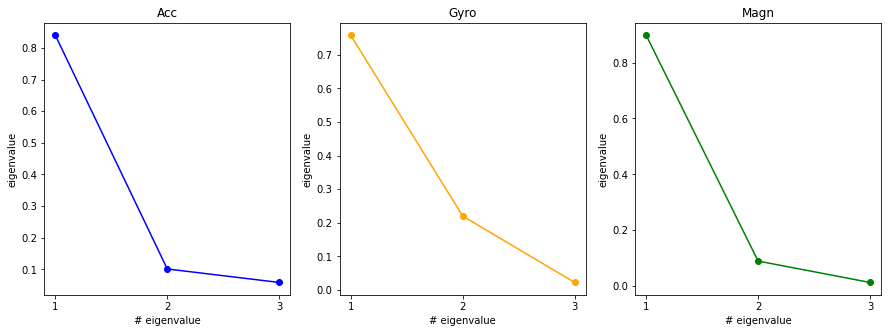

In [12]:
#Plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax1.plot(np.arange(U_acc.shape[0])+1, avl_acc_n, color = 'blue', marker = 'o')
ax1.set_title('Acc')
ax1.set_xlabel('# eigenvalue')
ax1.set_ylabel('eigenvalue')
ax1.xaxis.set_major_locator(MultipleLocator(1.000))
ax2.plot(np.arange(U_gyro.shape[0])+1, avl_gyro_n, color = 'orange', marker = 'o')
ax2.set_title('Gyro')
ax2.set_xlabel('# eigenvalue')
ax2.set_ylabel('eigenvalue')
ax2.xaxis.set_major_locator(MultipleLocator(1.000))
ax3.plot(np.arange(U_magn.shape[0])+1, avl_magn_n, color = 'green', marker = 'o')
ax3.set_title('Magn')
ax3.set_xlabel('# eigenvalue')
ax3.set_ylabel('eigenvalue')
ax3.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

Stampare autovalori

Anche in questo caso, per l'analisi da qui in poi, si è deciso di mantenere solo la prima componente principale di ogni dataset. Infatti, la variabilità contenuta in essa è di oltre l'80% per Acc, Magn e di oltre il 70% per Gyro.

A questo punto i dati sono stati ruotati nel nuovo sistema di riferimento.

In [13]:
# rotated dataset after PCA
rot = np.dot(dfc[['AccX','AccY','AccZ']],U_acc)
rot1 = np.dot(dfc[['GyroX','GyroY','GyroZ']],U_gyro)
rot2 = np.dot(dfc[['MagnX','MagnY','MagnZ']],U_magn)
dfr = pd.DataFrame({'Acc1': rot[:,0], 'Acc2': rot[:,1],'Acc3': rot[:,2],
                    'Gyro1': rot1[:,0], 'Gyro2': rot1[:,1],'Gyro3': rot1[:,2],
                    'Magn1': rot2[:,0], 'Magn2': rot2[:,1],'Magn3': rot2[:,2]})
dfr['Time'] = dfc['Time'].values
dfr

,Acc1,Acc2,Acc3,Gyro1,Gyro2,Gyro3,Magn1,Magn2,Magn3,Time
0,77.287233,-2.507985,-0.285016,-1.335900,-0.274420,0.149860,-30.228499,1.929195,1.455566,0.00
1,78.944173,-2.311280,6.225786,-0.757095,0.342773,0.356100,-31.176755,1.038458,1.058361,0.01
2,81.736447,-6.054412,-2.225147,0.210685,1.893214,0.499728,-32.371076,1.486182,0.524131,0.02
3,89.218377,-3.810653,-2.340794,0.326879,0.602079,0.504049,-30.407488,0.459231,-1.812972,0.03
4,95.958489,-1.012308,-5.922360,-0.536077,-0.409420,0.256171,-30.742025,1.814292,0.588166,0.04
...,...,...,...,...,...,...,...,...,...,...
12996,27.568386,-2.929290,-10.130334,-0.806151,0.417733,-0.018994,-10.612818,3.058089,-0.907519,129.96
12997,24.361317,2.695078,-12.455011,-0.349711,0.056676,0.285295,-11.895611,3.522412,1.096414,129.97
12998,42.606398,11.725767,-7.188652,-0.327730,0.230213,-0.079389,-11.460882,4.298246,0.626219,129.98
12999,28.164233,0.744890,-5.528476,0.187943,-0.299094,-0.014716,-12.141677,4.860874,0.959388,129.99


Text(0.5, 0, 'Time(s)')

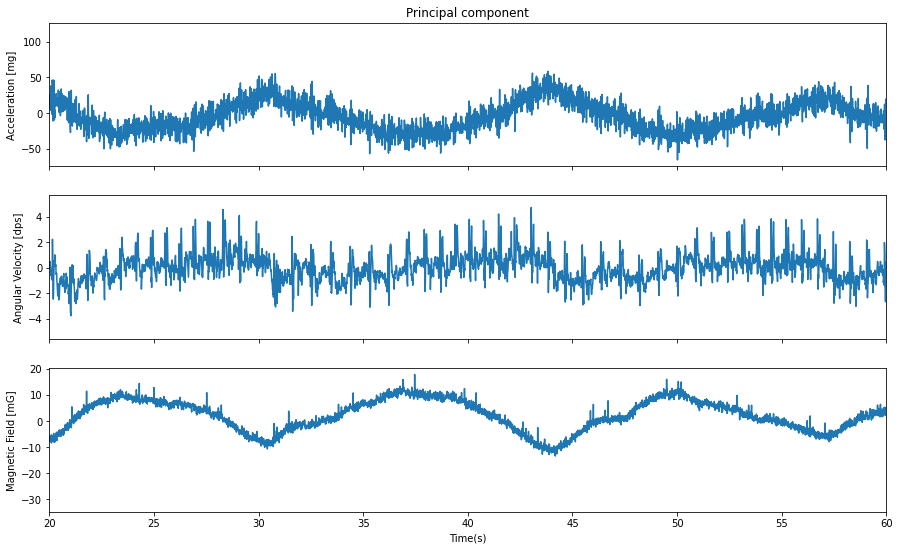

In [16]:
# principal component plots
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,9),sharex=True)
ax[0].plot(dfr['Time'],dfr['Acc1'])
ax[0].set_ylabel('Acceleration [mg]')
ax[0].set_title('Principal component')
ax[1].plot(dfr['Time'],dfr['Gyro1'])
ax[1].set_ylabel('Angular Velocity [dps]')
ax[2].plot(dfr['Time'],dfr['Magn1'])
ax[2].set_ylabel('Magnetic Field [mG]')

ax[2].set_xlim(20,60)
ax[2].set_xlabel('Time(s)')


## FFT analysis
Per ciascuna componente principale è stata calcolata la FFT per evidenziare la frequenza cardiaca nello spettro, tra 40BPM e 100BPM.

Text(0, 0.5, 'Amplitude')

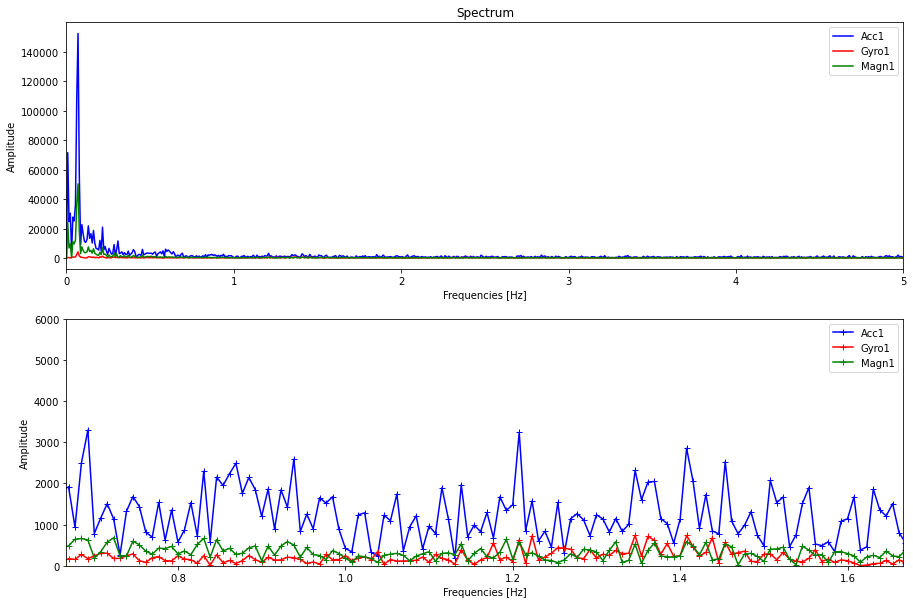

In [27]:
# HeartBeat freq
min_f=40./60.
max_f=100./60.

# FFT
A1_FFT = np.abs(np.fft.rfft(dfr['Acc1']))
G1_FFT = np.abs(np.fft.rfft(dfr['Gyro1']))
M1_FFT = np.abs(np.fft.rfft(dfr['Magn1']))
freq_FFT = np.fft.rfftfreq(d=1/freq, n=len(dfr['Acc1']))

#X = []
#YA = []
#YG = []
#for i in range(len(A1_FFT)):
#    if freq_FFT[i]<=max_f and freq_FFT[i]>=min_f:
#        X.append(freq_FFT[i])
#        YA.append(A1_FFT[i])
#        YG.append(G1_FFT[i])
        
#peakA,_ = signal.find_peaks(YA, height=4000)
#peakG,_ = signal.find_peaks(YG, height=1500)

#print('heart beat freq acc = %.3f +/- %.3f ' % (X[peakA[0]] ,0.009))
#print('heart beat freq gyro = %.3f +/- %.3f ' % (X[peakG[0]] ,0.009))

# spectrum
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (15,10))
ax1.plot(freq_FFT, A1_FFT,'b-', label='Acc1')
ax1.plot(freq_FFT, G1_FFT,'r-', label='Gyro1')
ax1.plot(freq_FFT, M1_FFT,'g-', label='Magn1')
ax1.set_xlim(0,5)
ax1.legend(loc='best')
ax1.set_xlabel('Frequencies [Hz]')
ax1.set_title('Spectrum')
ax1.set_ylabel('Amplitude')

ax2.plot(freq_FFT, A1_FFT,'b-+', label='Acc1')
ax2.plot(freq_FFT, G1_FFT,'r-+', label='Gyro1')
ax2.plot(freq_FFT, M1_FFT,'g-+', label='Magn1')
#plt.axvline(x = X[peakG[0]], color='k', linestyle='dashed', label='peak')
ax2.set_xlim(min_f, max_f)
ax2.set_ylim(0,6000)
ax2.legend(loc='best')
ax2.set_xlabel('Frequencies [Hz]')
ax2.set_ylabel('Amplitude')

Commento su quanto faccia schifo lo spettro

## SIGNAL FILTERING

Per ottenere una miglior stima del BPM si è proceduto con l'analisi e la pulizia dei segnali attraverso:

- Wavelet transform
- Hilbert envelop
- Bandpass filter (40-200)BPM (?)

In [29]:
sigA = dfr['Acc1']
sigG = dfr['Gyro1']
t = dfr['Time']

In [30]:
# wavelet
def wavelet_decomposition(t, signal, n, color):
    coeff = pywt.wavedec(signal, 'bior5.5', level = n)
    sigs = np.zeros((n+1,len(t)+1))
    for i in range(n+1):
        ca = coeff.copy()
        for j in range(n+1):
            if j != i: 
                ca[j] = np.zeros_like(ca[j])
        sigs[i] = pywt.waverec(ca, 'bior5.5')
    ax = []
    fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (15, 5), sharex=True)
    ax[n].set_xlabel('Time [s]')
    for i in range(n+1):
        ax[i].plot(t, sigs[i][:-1], color = color)
    return coeff

In [31]:
# bandpass filter
def FILTER(SIG,f1,f2):
    FFT = np.fft.rfft(SIG)
    freq = np.fft.rfftfreq(len(SIG), 1/100)
    filt = np.zeros_like(freq)
    filt[(freq>f1) & (freq<f2)] = 1
    for i in range(len(freq)):
        if freq[i] > f1:
            filt[i-1] = 2/3
            filt[i-2] = 1/3
            break
    for i in range(len(freq)):
        if freq[i] > f2:
            filt[i] = 2/3
            filt[i+1] = 1/3
            break
    new_FFT = FFT*filt
    new_SIG = np.fft.irfft(new_FFT, len(SIG))
    return new_SIG


 ## Gyroscope

[array([-1.56835458, -1.40477014, -1.2735726 , ..., -0.39105676,
        -0.92547747, -0.66252578]),
 array([ 0.24660667, -0.91467135,  0.48439343, ...,  0.16716975,
        -0.81979112,  0.07301306]),
 array([-0.14177985,  1.3839993 , -0.50697973, ..., -0.17914549,
         0.08143828, -0.17601286]),
 array([ 0.33742634, -0.21519332, -0.05356996, ...,  0.2829976 ,
         0.14138521,  0.30787741])]

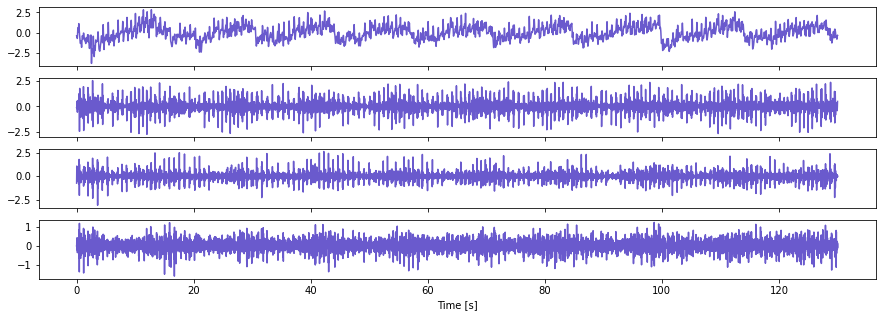

In [116]:
n=3
CG = wavelet_decomposition(t, sigG, n, 'slateblue')
CG

Text(0.5, 1.0, 'Wavelet Filtered Signal')

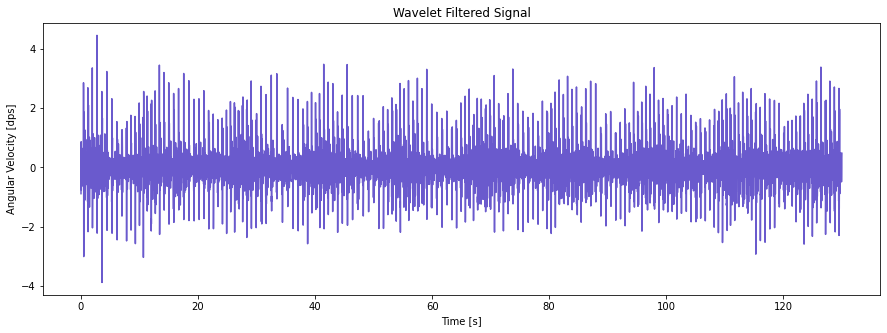

In [117]:
# filtered signal after wavelet decomposition
cg = CG.copy()
for j in range(n+1):
    if (j!=1) & (j!=2): 
        cg[j] = np.zeros_like(cg[j])
sigG_w = pywt.waverec(cg, 'bior5.5')
SIGG = sigG_w[:-1]

plt.figure(figsize=(15,5))
plt.plot(t, SIGG, color = 'slateblue')
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [dps]')
plt.title('Wavelet Filtered Signal')

Text(0.5, 0, 'Time [s]')

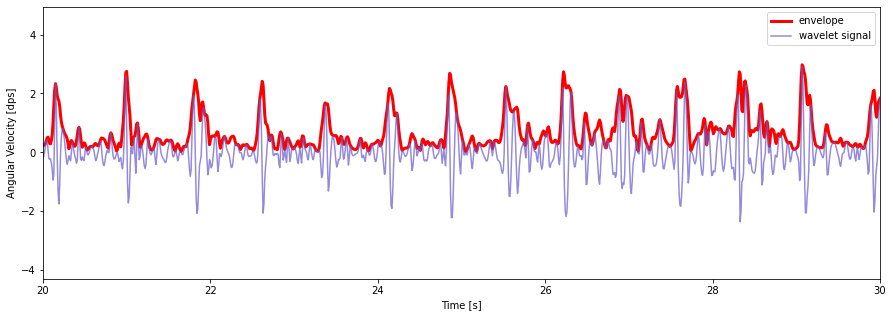

In [118]:
# envelope
SIGG_h = np.abs(signal.hilbert(SIGG))

plt.figure(figsize=(15,5))
plt.plot(t, SIGG_h, color = 'r', linewidth=3, label='envelope')
plt.plot(t, SIGG, 'slateblue', alpha=0.7, label='wavelet signal')
plt.legend(loc='best')
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')

Text(0.5, 1.0, 'Filtered Signal')

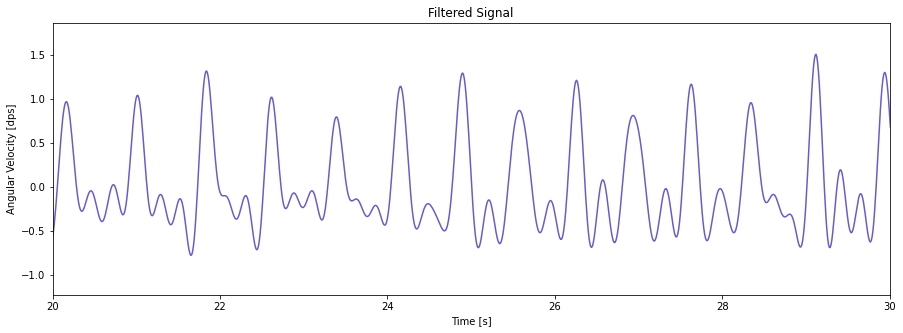

In [119]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 4

signal_G = FILTER(SIGG_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_G , 'slateblue')
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')

## Accelerometer

[array([236.03297452, 244.96471387, 241.93758114, ...,  89.48289915,
         84.71324662,  84.84586338]),
 array([ -1.63919925, -22.2032871 ,   9.35845126, ...,   0.81499766,
         -7.30804207,  -6.21177409]),
 array([-4.23842481, -4.74273073,  5.62341412, ..., -5.83646316,
        -6.99034374,  7.37422427]),
 array([ -1.67128677,   0.78419646,   0.33862481, ...,  -8.2961683 ,
        -10.42314371,   0.33169459])]

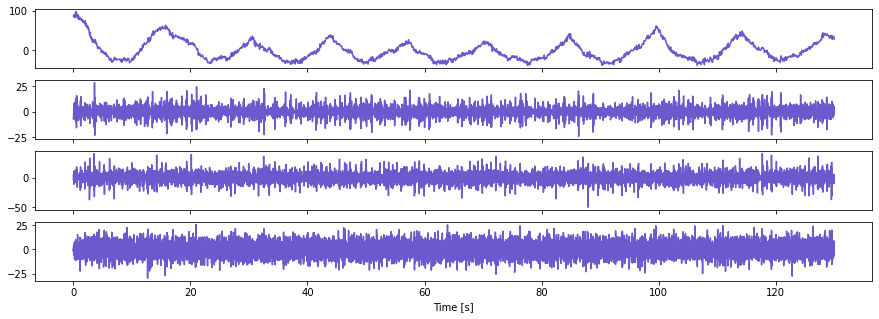

In [120]:
CA = wavelet_decomposition(t, sigA, 3, 'slateblue')
CA

Text(0.5, 1.0, 'Wavelet Filtered Signal')

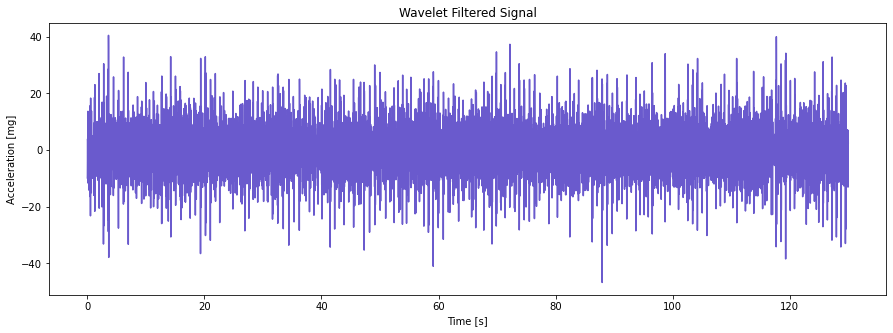

In [121]:
# filtered signal after wavelet decomposition
ca = CA.copy()
for j in range(n+1):
    if (j!=1) & (j!=2): 
        ca[j] = np.zeros_like(ca[j])
sigA_w = pywt.waverec(ca, 'bior5.5')
SIGA = sigA_w[:-1]

plt.figure(figsize=(15,5))
plt.plot(t, SIGA, color = 'slateblue')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [mg]')
plt.title('Wavelet Filtered Signal')

Text(0.5, 0, 'Time [s]')

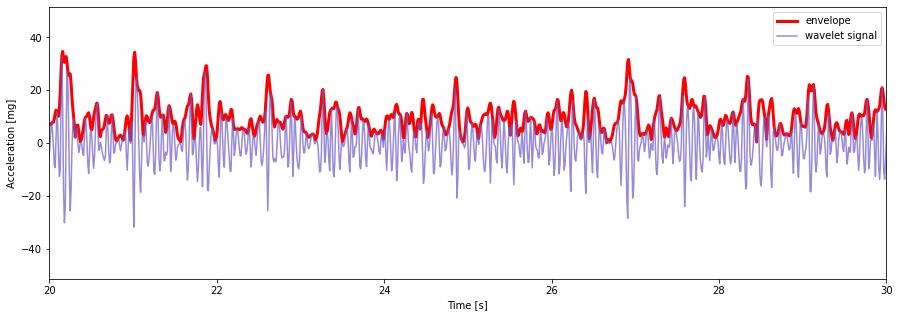

In [122]:
# envelope
SIGA_h = np.abs(signal.hilbert(SIGA))

plt.figure(figsize=(15,5))
plt.plot(t, SIGA_h, color = 'r', linewidth=3, label='envelope')
plt.plot(t, SIGA, 'slateblue', alpha=0.7, label='wavelet signal')
plt.legend(loc='best')
plt.xlim(20, 30)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')

Text(0.5, 1.0, 'Filtered Signal')

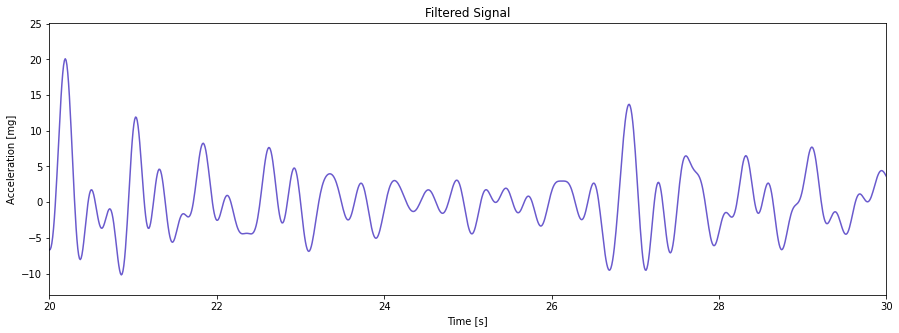

In [123]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 4

signal_A = FILTER(SIGA_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_A , 'slateblue')
plt.xlim(20, 30)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')

## Find peaks

In [124]:
# function to plot HRV and BPM histo
def histo_func(bins1,peaks1,t):
    peaks_time1=t[peaks1]
    period1 = peaks_time1[1:]-peaks_time1[:-1]
    rate1 = 1/period1*60

    fig = plt.figure(figsize=(12,6))
    gs = GridSpec(3,3)

    ax_main = fig.add_subplot(gs[:,:2])
    ax_marg = fig.add_subplot(gs[:,2])
    ax_main.plot((peaks_time1[1:]+peaks_time1[:-1])*0.5,rate1,marker='o')
    ax_main.set_xlabel('Time (s)')
    ax_main.set_ylabel('Heart BPM')
    ax_main.set_title('Heart BPM as a function of time and histogram')
    l=ax_main.get_ylim()
    h1,b1,_=ax_marg.hist(x=rate1, bins=bins1,orientation='horizontal')
    bin_center1=(b1[1:]+b1[:-1])*0.5
    ax_marg.set_ylim(l)

In [125]:
# function to fix peaks
def to_fix_peaks(time,peaks,data,thr,r=0.5):
    
    peaks_time=time[peaks]
    period = peaks_time[1:]-peaks_time[:-1]
    #rate = 1/period*60
    
    peaks_new=peaks.copy()
    diff_mean=np.mean(np.abs(period[1:]-period[:-1]))
    for i in np.arange(1,len(period)-1):
        
        peaks_time=time[peaks_new]
        period = peaks_time[1:]-peaks_time[:-1]    
        to_check=np.abs(period[i]-period[i+1])
        
        if to_check>2*(diff_mean):
            if thr==None: new_thr=-m.inf
            else:  new_thr=0.33*(thr+data[peaks_new[i+1]])
                
            if period[i]-period[i+1]>0:
                array=data[(time<time[peaks_new[i+1]]) & (time>time[peaks_new[i+1]]-r)]
                der = array[1:]-array[:-1]
                change=[]
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0 and array[d+1]>new_thr: change=np.append(change,d+1)
                if len(change)>0:
                    peaks_new[i+1]= peaks_new[i+1]-len(array)+change[-1]
                    peaks_time=time[peaks_new]
                    period = peaks_time[1:]-peaks_time[:-1]
                if np.abs(period[i]-period[i+1])>to_check:
                    peaks_new[i+1]= peaks[i+1]                    
                
            if period[i]-period[i+1]<0: #
                array=data[(time>time[peaks_new[i+1]]) & (time<time[peaks_new[i+1]]+r)]
                der = array[1:]-array[:-1]
                change=np.array([])
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0 and array[d+1]>new_thr: change=np.append(change,d+1)
                if len(change)>0:
                    peaks_new[i+1]= peaks_new[i+1] + change[0] +1
                    peaks_time=time[peaks_new]
                    period = peaks_time[1:]-peaks_time[:-1]
                if np.abs(period[i]-period[i+1])>to_check:
                    peaks_new[i+1]= peaks[i+1] 
                
    plt.figure(figsize=(10,4))
    plt.plot(time,data)
    #plt.plot(time,sigA,color='grey',alpha=0.5)
    plt.plot(time[peaks],data[peaks], 'rx', label='old peaks')
    plt.plot(time[peaks_new],data[peaks_new], 'gx', label='new peaks')
    plt.legend(loc='upper right')
    return peaks_new

Text(0.5, 1.0, 'Peaks Detection')

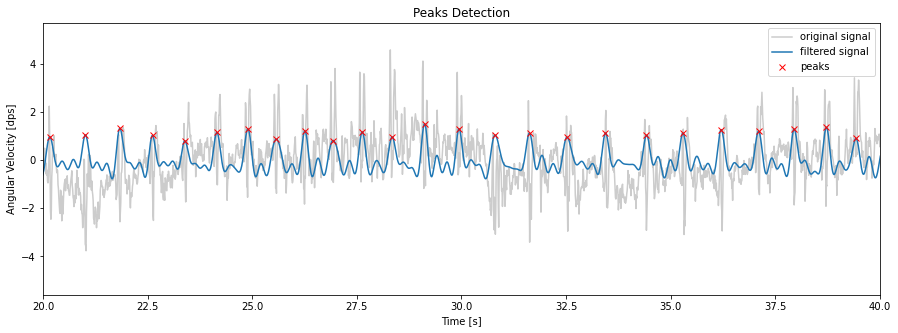

In [134]:
# gyroscope peaks
plt.figure(figsize=(15,5))
plt.plot(t,sigG, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_G,label='filtered signal')
peaksG,_ = signal.find_peaks(signal_G, height=0.3 , distance=50)
plt.plot(t[peaksG],signal_G[peaksG], 'rx', label='peaks')
plt.xlim(20,40)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')

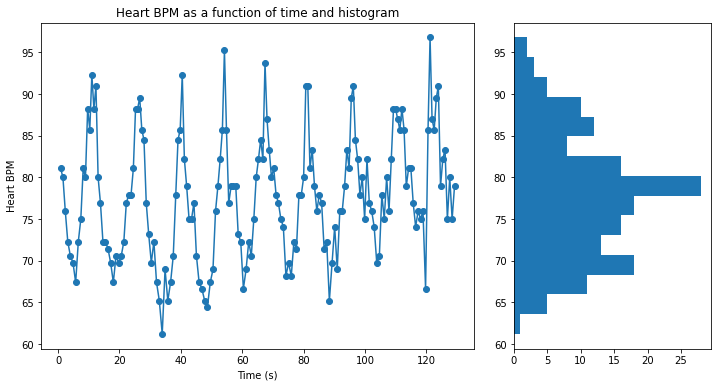

In [127]:
# HRV and BPM histo
histo_func(15,peaksG,t.values)

In [128]:
#se da correggere:
#peaks_new_G = to_fix_peaks(t.values,peaksG,signal_G,thr=0,r=0.3)

In [129]:
#histo_func(10,peaksG,t.values)
#histo_func(10,peaks_new_G,t.values)

Text(0.5, 1.0, 'Peaks Detection')

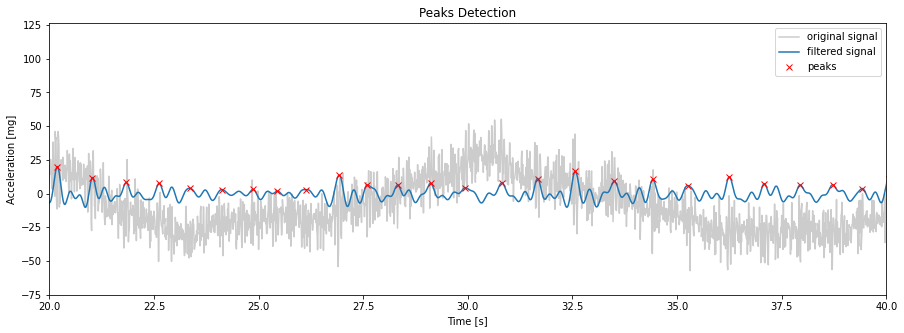

In [130]:
# accelerometer
plt.figure(figsize=(15,5))
plt.plot(t,sigA, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_A,label='filtered signal')
peaksA,_ = signal.find_peaks(signal_A, height=0 , distance=50)
plt.plot(t[peaksA],signal_A[peaksA], 'rx', label='peaks')
plt.xlim(20,40)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')

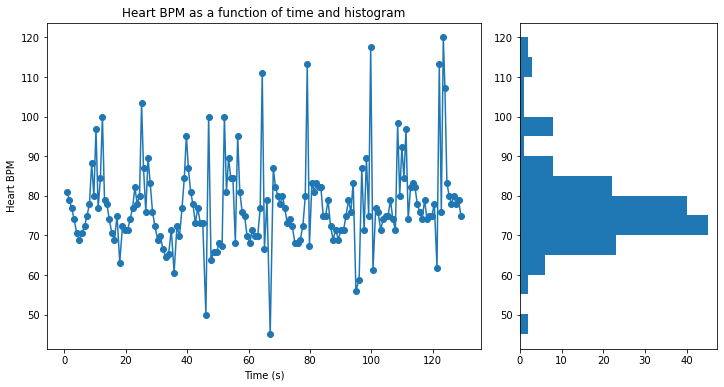

In [131]:
# HRV and BPM histo
histo_func(15,peaksA,t.values)

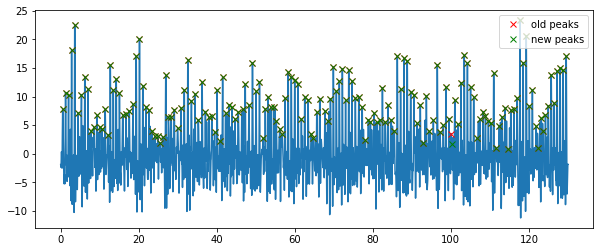

In [132]:
# fixed peaks for the accelerometer
peaks_new_A = to_fix_peaks(t.values,peaksA,signal_A,thr=0,r=0.3)

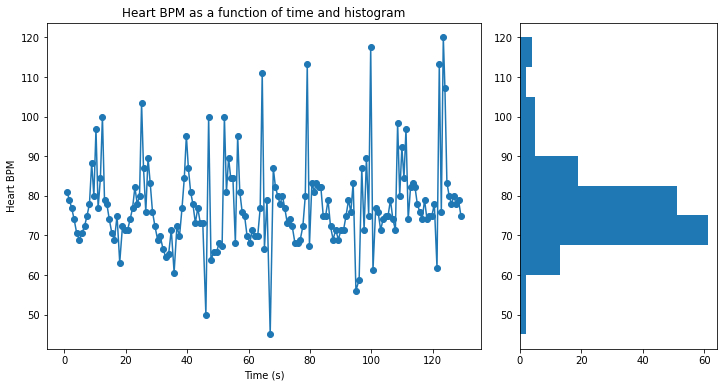

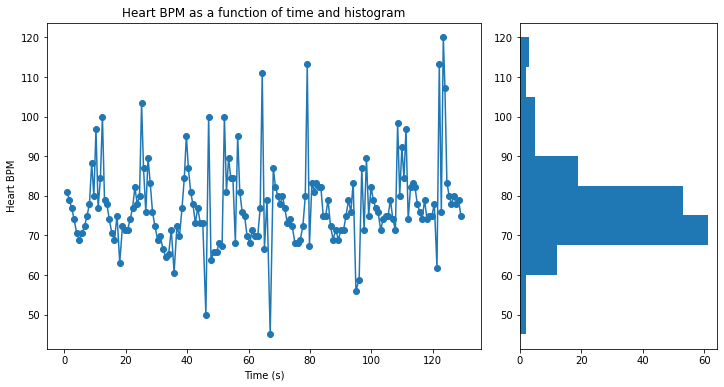

In [133]:
histo_func(10,peaksA,t.values)
histo_func(10,peaks_new_A,t.values)

# peaks errors and KDE

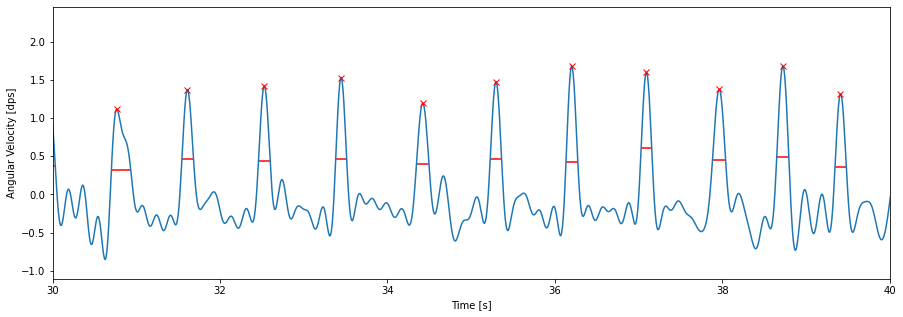

In [100]:
# gyroscope
widths = signal.peak_widths(signal_G, peaks_new_G, rel_height=0.5)

plt.figure(figsize=(15,5))
plt.plot(t.values,signal_G)
plt.plot(t.values[peaks_new_G], signal_G[peaks_new_G],'rx')
plt.hlines(widths[1],xmin=0.01*widths[2],xmax=0.01*widths[3],color='red')
plt.xlim(30,40)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.show()

Text(0.5, 0, 'BPM')

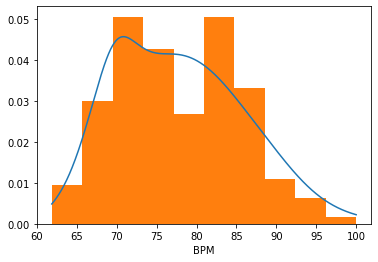

In [103]:
# KDE gyroscope
#uncertainties as unc

const = 2*(2*np.log(2))**0.5
sigma = widths[0]/const*0.01

#peaks_time=np.array([unc.ufloat(t.values[peaksG][i],sigma[i]) for i in range(len(peaksG))])
peaks_time=np.array(t.values[peaksG])

period = peaks_time[1:] - peaks_time[:-1]
sigma_period = (sigma[1:]**2 + sigma[:-1]**2)**0.5
rate = 1/period*60
err_rate = rate/period*sigma_period
#rate_val=np.array([rate[i].n for i in range(len(rate))])
#rate_err=np.array([rate[i].s for i in range(len(rate))])

#KDE gyroscopio
xx = np.linspace(min(rate),max(rate),1000)
fx = np.zeros(xx.shape)
for r,s in zip(rate,err_rate*1.06*err_rate.size**(-1/5)):
    fx += norm.pdf(xx,r,s)

fx = fx/trapz(fx,xx)
plt.plot(xx, fx, label='KDE')
plt.hist(rate, bins=10, density=True)
plt.xlabel('BPM')

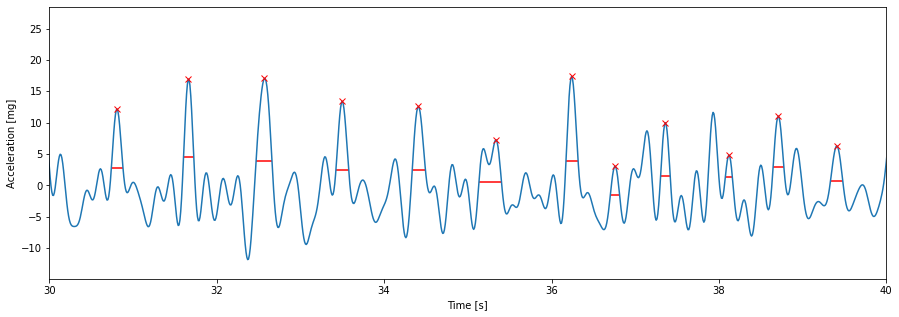

In [92]:
# accelerometer
widths = signal.peak_widths(signal_A, peaks_new_A, rel_height=0.5)

plt.figure(figsize=(15,5))
plt.plot(t.values,signal_A)
plt.plot(t.values[peaks_new_A], signal_A[peaks_new_A],'rx')
plt.hlines(widths[1],xmin=0.01*widths[2],xmax=0.01*widths[3],color='red')
plt.xlim(30,40)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.show()

(array([0.02472032, 0.04944063, 0.03884621, 0.04590916, 0.02589747,
        0.00588579, 0.00235432, 0.00117716, 0.00117716, 0.00117716]),
 array([ 64.51612903,  69.60297767,  74.6898263 ,  79.77667494,
         84.86352357,  89.95037221,  95.03722084, 100.12406948,
        105.21091811, 110.29776675, 115.38461538]),
 <a list of 10 Patch objects>)

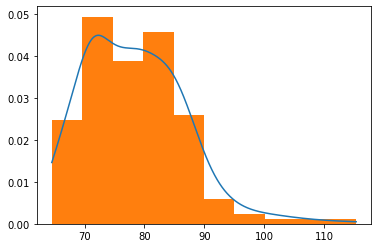

In [97]:
# KDE accelerometer
#import uncertainties as unc

const = 2*(2*np.log(2))**0.5
sigma = widths[0]/const*0.01

#peaks_time=np.array([unc.ufloat(t.values[peaksG][i],sigma[i]) for i in range(len(peaksG))])
peaks_time = np.array(t.values[peaks_new_A])

period = peaks_time[1:] - peaks_time[:-1]
sigma_period = (sigma[1:]**2 + sigma[:-1]**2)**0.5
rate = 1/period*60
err_rate = rate/period*sigma_period
#rate_val=np.array([rate[i].n for i in range(len(rate))])
#rate_err=np.array([rate[i].s for i in range(len(rate))])

#KDE accelerometro
xx = np.linspace(min(rate),max(rate),1000)
fx = np.zeros(xx.shape)
for r,s in zip(rate,err_rate*1.06*err_rate.size**(-1/5)):
    fx += norm.pdf(xx,r,s)

fx = fx/trapz(fx,xx)
plt.plot(xx, fx, label='KDE')
plt.hist(rate, bins=10, density=True)
plt.xlabel('BPM')